In [2]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np
import time

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score

import plotly.express as px
import TsModel
import GprModel
from sklearn.utils import validation
from windrose import WindroseAxes
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.path import Path
from matplotlib.transforms import Affine2D
from matplotlib.patches import Circle, RegularPolygon

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
plt.rcParams.update({'font.size': 18})

In [6]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [7]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y):    
    ts_model = TsModel.TsModel(number_of_rules=30, early_end_threshold=1e-8, fuzzification_coefficient=1.2)
    _, rmse_train, _ = ts_model.fit(train_x,train_y)
    
    y_hat_validation = ts_model.predict(validation_x)
    rmse_validation = mean_squared_error(validation_y, y_hat_validation,squared=False)

    return rmse_train, rmse_validation

In [11]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [1,2,3,4,5,6,7,8,9, 10,11,12]

# Expeirment related parameters
number_of_folds = 10 # have to be 10 fold

# Results containers
training_results_fcm_min_feature = []
test_results_fcm_min_feature = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    for hyperparameter_value in hyper_parameter_to_test_values:
        # Station data is generated already, only need to train the model
        flatten_train_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x.csv", index_col=0).to_numpy()
        flatten_train_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

        # Test data should still need to be generated
        flatten_test_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x_test.csv", index_col=0).to_numpy()
        flatten_test_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        training_times_fold = []
        test_results_fold = []
        nn_history_fold = []
            
        for i in range(0, number_of_folds):
            flatten_train_x, flatten_train_y = shuffle(flatten_train_x, flatten_train_y)
    
            flatten_train_x = np.asarray(flatten_train_x).astype('float32')
            flatten_train_y = np.asarray(flatten_train_y).astype('float32')
            flatten_test_x = np.asarray(flatten_test_x).astype('float32')
            flatten_test_y = np.asarray(flatten_test_y).astype('float32')
            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")

            # Normalize the input
            norm_flatten_train_x, norm_flatten_test_x = preprocess_data(flatten_train_x, flatten_test_x)            
         
            # FCM model
            fcm_train_rmse, fcm_val_rmse = fcm_rule_model(norm_flatten_train_x, flatten_train_y, norm_flatten_test_x , flatten_test_y)
            training_results_fold.append({'fcm_train' : fcm_train_rmse})
            test_results_fold.append({'fcm_test' : fcm_val_rmse})
        
        #After all folds are done, update the result containers
        training_results_fcm_min_feature.append(training_results_fold)
        test_results_fcm_min_feature.append(test_results_fold)
        

In [12]:
do_experiment(number_of_neighbour_stations)

Currently running fold 0 for 1 stations
FCM training RMSE: 7.043654532387965
Currently running fold 1 for 1 stations
FCM training RMSE: 7.06034626502913
Currently running fold 2 for 1 stations
FCM training RMSE: 7.0549566464154045
Currently running fold 3 for 1 stations
FCM training RMSE: 7.062768799184367
Currently running fold 4 for 1 stations
FCM training RMSE: 7.052874837714568
Currently running fold 5 for 1 stations
FCM training RMSE: 7.040193554061719
Currently running fold 6 for 1 stations
FCM training RMSE: 7.0617275749213855
Currently running fold 7 for 1 stations
FCM training RMSE: 7.041832291934176
Currently running fold 8 for 1 stations
FCM training RMSE: 7.051076520161345
Currently running fold 9 for 1 stations
FCM training RMSE: 7.047860385757007
Currently running fold 0 for 2 stations
FCM training RMSE: 6.474651208568339
Currently running fold 1 for 2 stations
FCM training RMSE: 6.478022479233387
Currently running fold 2 for 2 stations
FCM training RMSE: 6.44926266868787

FCM training RMSE: 5.586700994273035
Currently running fold 7 for 11 stations
FCM training RMSE: 5.6012905742933
Currently running fold 8 for 11 stations
FCM training RMSE: 5.5798409430543385
Currently running fold 9 for 11 stations
FCM training RMSE: 5.597191830558039
Currently running fold 0 for 12 stations
FCM training RMSE: 5.551500009723338
Currently running fold 1 for 12 stations
FCM training RMSE: 5.571620865706279
Currently running fold 2 for 12 stations
FCM training RMSE: 5.563430232917702
Currently running fold 3 for 12 stations
FCM training RMSE: 5.558960718383531
Currently running fold 4 for 12 stations
FCM training RMSE: 5.552661952462234
Currently running fold 5 for 12 stations
FCM training RMSE: 5.551306073732281
Currently running fold 6 for 12 stations
FCM training RMSE: 5.557810051037049
Currently running fold 7 for 12 stations
FCM training RMSE: 5.542280696431004
Currently running fold 8 for 12 stations
FCM training RMSE: 5.555740626036726
Currently running fold 9 for

In [29]:
# Save the current experiment result and resume when needed
# Modified from source: https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later

# training_results_single_feature = training_results
# test_results_single_feature = test_results

# %store training_results_fcm_min_feature
# %store test_results_fcm_min_feature

#closing seesion, restarting kernel

# %store -r training_results_single_feature
# %store -r test_results_single_feature
# %store -r training_results_fcm_min_feature
# %store -r test_results_fcm_min_feature

Stored 'training_results_fcm_min_feature' (list)
Stored 'test_results_fcm_min_feature' (list)


In [33]:
print(training_results_fcm_min_feature)

print(test_results_fcm_min_feature)

[[{'fcm_train': 7.043654532387965}, {'fcm_train': 7.06034626502913}, {'fcm_train': 7.0549566464154045}, {'fcm_train': 7.062768799184367}, {'fcm_train': 7.052874837714568}, {'fcm_train': 7.040193554061719}, {'fcm_train': 7.0617275749213855}, {'fcm_train': 7.041832291934176}, {'fcm_train': 7.051076520161345}, {'fcm_train': 7.047860385757007}], [{'fcm_train': 6.474651208568339}, {'fcm_train': 6.478022479233387}, {'fcm_train': 6.449262668687876}, {'fcm_train': 6.455355576717576}, {'fcm_train': 6.448061454359812}, {'fcm_train': 6.477141171402401}, {'fcm_train': 6.468948768014893}, {'fcm_train': 6.4900784358907195}, {'fcm_train': 6.468462350456162}, {'fcm_train': 6.4657457850436355}], [{'fcm_train': 6.05595664777785}, {'fcm_train': 6.0518643017668134}, {'fcm_train': 6.052527542610967}, {'fcm_train': 6.065780705996854}, {'fcm_train': 6.037447214067526}, {'fcm_train': 6.055392527163504}, {'fcm_train': 6.049765894496198}, {'fcm_train': 6.054033670008295}, {'fcm_train': 6.042237511402188}, {'fcm

exp
7.3231000900268555±0.0
7.1188±0.0053
exp
7.1732001304626465±0.0
6.4136±0.0318
exp
7.019700050354004±0.0
5.9383±0.0099
exp
6.906799793243408±0.0
5.7758±0.0036
exp
6.777200222015381±0.0
5.7107±0.0026
exp
6.840400218963623±0.0
5.674±0.0051
exp
6.932799816131592±0.0
5.6383±0.0047
exp
6.945499897003174±0.0
5.6262±0.0029
exp
6.74560022354126±0.0
5.6119±0.0029
exp
6.809599876403809±0.0
5.6061±0.0036
exp
6.924200057983398±0.0
5.5996±0.0042
exp
6.903200149536133±0.0
5.5847±0.0067
exp fcm train
7.0517±0.0079
exp fcm train
6.4676±0.0128
exp fcm train
6.0519±0.0073
exp fcm train
5.8533±0.0088
exp fcm train
5.7927±0.0087
exp fcm train
5.7047±0.0051
exp fcm train
5.6778±0.0087
exp fcm train
5.6563±0.0047
exp fcm train
5.631±0.0039
exp fcm train
5.5959±0.0045
exp fcm train
5.5945±0.007
exp fcm train
5.5556±0.0076


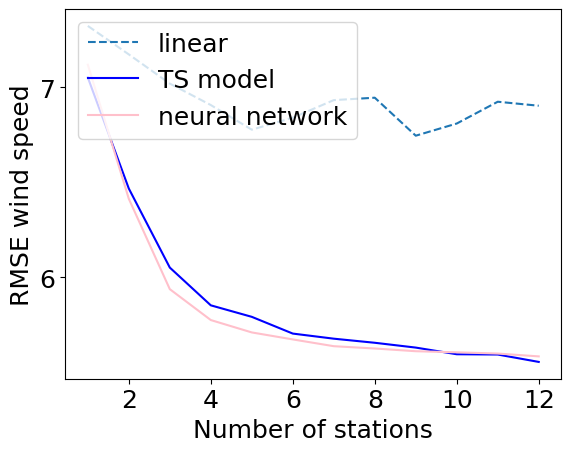

In [41]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in training_results_single_feature:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))
     #gpr_train_plot.append(np.mean([d['gpr_train'] for d in exp if 'nn_train' in d]))


for exp in training_results_fcm_min_feature:
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     #gpr_train_plot.append(np.mean([d['gpr_train'] for d in exp if 'nn_train' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on training data')

for exp in training_results_single_feature:
    print('exp')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")


for exp in training_results_fcm_min_feature:
    print('exp fcm train')
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")


exp
7.332799911499023±0.0
7.123±0.0051
exp
7.180799961090088±0.0
6.4±0.0313
exp
7.0304999351501465±0.0
5.9292±0.0098
exp
6.915299892425537±0.0
5.7671±0.0033
exp
6.783999919891357±0.0
5.6984±0.0025
exp
6.853300094604492±0.0
5.669±0.0064
exp
6.934899806976318±0.0
5.6361±0.0056
exp
6.954400062561035±0.0
5.624±0.0038
exp
6.748300075531006±0.0
5.6106±0.0025
exp
6.820300102233887±0.0
5.6121±0.0043
exp
6.937900066375732±0.0
5.6074±0.0046
exp
6.923600196838379±0.0
5.5908±0.006
fcm exp
7.0657±0.0085
fcm exp
6.4703±0.0145
fcm exp
6.0618±0.0077
fcm exp
5.8669±0.0092
fcm exp
5.8032±0.0092
fcm exp
5.7258±0.0047
fcm exp
5.6916±0.0088
fcm exp
5.671±0.0046
fcm exp
5.6448±0.0046
fcm exp
5.6182±0.0048
fcm exp
5.6137±0.0063
fcm exp
5.5785±0.0071


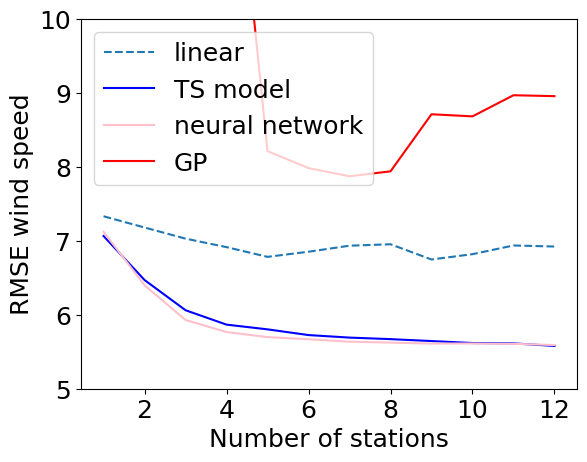

In [37]:
# The fcm testing data is MSE not RMSE

li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_plot = []
x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in test_results_single_feature:
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     #fcm_train_plot.append(np.mean([np.sqrt(d['fcm_test']) for d in exp if 'fcm_test' in d]))
     gpr_plot.append(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))

for exp in test_results_fcm_min_feature:
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, gpr_plot, label='GP', c='red')
plt.legend(loc="upper left")
plt.ylim(5,10)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on testing data')

for exp in test_results_single_feature:
    print('exp')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")


for exp in test_results_fcm_min_feature:
    print('fcm exp')
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")


In [3]:
opt_x = pd.read_csv('Data/exp/5x_test.csv', index_col=0)
opt_y = pd.read_csv('Data/exp/5y_test.csv', index_col=0)